In [2]:
import pandas as pd
import numpy as np
from pandarallel import pandarallel
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib as mpl
import rich.console
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error



_orig_console = rich.console.Console


class Console(_orig_console):
    def __init__(self, *args, **kwargs):
        kwargs["force_terminal"] = True
        super().__init__(*args, **kwargs)


rich.console.Console = Console
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
pandarallel.initialize(progress_bar=False, nb_workers=16)
base_dir="/root/vllm/examples/analysis/data/eos_result/"

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [15]:
colors = ["#1C445C", "#008087", "#6D8764", "#A0522D", "#76608A"]
self_define_palette = sns.color_palette(colors)

# EoS Prob Analysis

In [3]:
model_names = [
    "llama",
]
dataset_names = ["lmsys"]
dataset_name_map = {"lmsys": "LMSys"}
model_name_map = {"llama": "Llama"}

eos_prob_rank_result_df = pd.DataFrame()
for model_name in model_names:
    for dataset_name in dataset_names:
        tmp_df = pd.read_csv(f"{base_dir}{model_name}_{dataset_name}_eos_prob_result.csv")
        tmp_df["model_dataset"] = model_name_map[model_name] + " " + dataset_name_map[dataset_name]
        eos_prob_rank_result_df = pd.concat([eos_prob_rank_result_df, tmp_df])
eos_prob_rank_result_df = eos_prob_rank_result_df[eos_prob_rank_result_df["eos_prob"] != 0]

In [4]:
prompt_len_result = (
    eos_prob_rank_result_df.loc[:10000, ["model_dataset", "request_id", "prompt_len", "token_num"]]
    .groupby(["model_dataset", "request_id"])
    .max()
    .reset_index()
)
X = prompt_len_result.loc[:4000, "prompt_len"].values.reshape(-1, 1)
y = prompt_len_result.loc[:4000, "token_num"]
test_X = prompt_len_result.loc[4000:, "prompt_len"].values.reshape(-1, 1)

model = LinearRegression()
model.fit(X, y)
test_y = model.predict(prompt_len_result.loc[:, "prompt_len"].values.reshape(-1, 1))
prompt_len_result.loc[:, "test_y"] = test_y


def get_accuracy(prompt_len_result):
    prompt_len_result_merge = (
        prompt_len_result.assign(key=1).merge(prompt_len_result.assign(key=1), on="key").drop("key", axis=1)
    )
    prompt_len_result_merge["req_ids"] = (
        prompt_len_result_merge["request_id_x"] + prompt_len_result_merge["request_id_y"]
    )
    filter1 = prompt_len_result_merge["test_y_x"] >= prompt_len_result_merge["test_y_y"]
    filter2 = prompt_len_result_merge["token_num_x"] <= prompt_len_result_merge["token_num_y"]
    filter3 = prompt_len_result_merge["test_y_x"] <= prompt_len_result_merge["test_y_y"]
    filter4 = prompt_len_result_merge["token_num_x"] >= prompt_len_result_merge["token_num_y"]
    accuracy = len(prompt_len_result_merge[(filter1 & filter2) | (filter3 & filter4)]) / len(prompt_len_result_merge)
    return accuracy


get_accuracy(prompt_len_result[4000:])

ZeroDivisionError: division by zero

In [88]:

from concurrent.futures import ProcessPoolExecutor, as_completed
def calc_expected_left_length(row, init_length):
    if max(row["token_num"]) < init_length:
        return -1, -1
    differences = []
    left_token_nums = []
    token_nums = max(row["token_num"])
    eos_token_ranks = row["eos_prob"].tolist()
    for i in range(init_length, token_nums):
        #     # differences.append(np.mean(eos_token_ranks[i-init_length:i]))
        #     # differences.append(
        #     #     np.max(eos_token_ranks[i - init_length : i]) - np.min(eos_token_ranks[i - init_length : i])
        #     # )
        #     differences.append(np.std(eos_token_ranks[i - init_length : i]) + np.mean(eos_token_ranks[i - init_length : i]))
        differences.append(np.max(eos_token_ranks[i - init_length : i]) - np.min(eos_token_ranks[i - init_length : i]))
        left_token_nums.append(token_nums - i)
    # i = init_length
    # differences = (
    #     np.max(eos_token_ranks[:init_length])
    #     - np.min(eos_token_ranks[:init_length])
    # ) / init_length
    # average_difference = np.mean(differences)
    # differences = np.diff(max_eos_token_rank[:5])
    # left_token_nums.append(token_nums - i)
    # differences.append(np.max(eos_token_ranks[i - init_length : i]) - np.min(eos_token_ranks[i - init_length : i]))
    # differences = np.std(eos_token_ranks[:init_length])
    return differences, left_token_nums


def get_estimate_accuracy(expected_accuracy, model):
    llama_alpaca_expected_accuracy = expected_accuracy[expected_accuracy["model_dataset"] == model]
    print(len(llama_alpaca_expected_accuracy))
    selected_llama_alpaca_expected_accuracy = llama_alpaca_expected_accuracy[:]
    llama_alpaca_expected_accuracy_merge = (
        selected_llama_alpaca_expected_accuracy.assign(key=1)
        .merge(selected_llama_alpaca_expected_accuracy.assign(key=1), on="key")
        .drop("key", axis=1)
    )
    llama_alpaca_expected_accuracy_merge["req_ids"] = (
        llama_alpaca_expected_accuracy_merge["request_id_x"] + llama_alpaca_expected_accuracy_merge["request_id_y"]
    )
    llama_alpaca_expected_accuracy_merge = llama_alpaca_expected_accuracy_merge.drop_duplicates(subset="req_ids")
    filter1 = (
        llama_alpaca_expected_accuracy_merge["eos_prob_diff_x"]
        >= llama_alpaca_expected_accuracy_merge["eos_prob_diff_y"]
    )
    filter2 = (
        llama_alpaca_expected_accuracy_merge["max_token_nums_x"]
        <= llama_alpaca_expected_accuracy_merge["max_token_nums_y"]
    )
    filter3 = (
        llama_alpaca_expected_accuracy_merge["eos_prob_diff_x"]
        <= llama_alpaca_expected_accuracy_merge["eos_prob_diff_y"]
    )
    filter4 = (
        llama_alpaca_expected_accuracy_merge["max_token_nums_x"]
        >= llama_alpaca_expected_accuracy_merge["max_token_nums_y"]
    )
    accuracy = len(llama_alpaca_expected_accuracy_merge[(filter1 & filter2) | (filter3 & filter4)]) / len(
        llama_alpaca_expected_accuracy_merge
    )
    return accuracy


def get_expected_accuracy_df(eos_prob_rank_result_df, init_length):
    expected_accuracy = (
        eos_prob_rank_result_df.groupby(["request_id", "model_dataset"])
        .parallel_apply(
            lambda row: pd.Series(
                calc_expected_left_length(row, init_length),
                index=["eos_prob_diff", "max_token_nums"],
            )
        )
        .reset_index()
    )
    expected_accuracy = expected_accuracy[expected_accuracy["eos_prob_diff"] != -1]
    return expected_accuracy


def process_model_init_length(args):
    init_length, model, eos_prob_rank_result_df = args
    selected_sequences_num = [i for i in range(2000, 8000, 1)]
    eos_prob_rank_result_df = eos_prob_rank_result_df[
        eos_prob_rank_result_df["request_id"].isin(selected_sequences_num)
    ]
    expected_accuracy = get_expected_accuracy_df(eos_prob_rank_result_df, init_length)
    accuracy = get_estimate_accuracy(expected_accuracy, model)
    return model, init_length, accuracy



models = [
    # "Llama Alpaca",
    # "Llama ShareGPT",
    "Llama LMSys"
    # "Mistral Alpaca",
    # "Mistral ShareGPT",
]
init_lengths = [i for i in range(3, 17)]
estimated_accuracy = {"models": [], "init_length": [], "accuracy": []}
# Parallel execution
with ProcessPoolExecutor() as executor:
    futures = []
    for init_length in init_lengths:
        # expected_accuracy_df = get_expected_accuracy_df(eos_prob_rank_result_df, init_length)
        for model in models:
            # Pass necessary arguments as a tuple to the function
            args = (init_length, model, eos_prob_rank_result_df)
            futures.append(executor.submit(process_model_init_length, args))

    # Collect results as they complete
    for future in as_completed(futures):
        try:
            model, init_length, accuracy = future.result()
            estimated_accuracy["models"].append(model)
            estimated_accuracy["init_length"].append(init_length)
            estimated_accuracy["accuracy"].append(accuracy)
        except Exception as e:
            print(f"An error occurred: {e}")

estimated_accuracy = pd.DataFrame(estimated_accuracy)
estimated_accuracy.to_csv(f"{base_dir}/estimated_accuracy_cov.csv")

5810
5760
5700
5587
5495
5404
5352
5279
5227
5178
5136
5096
5048
4987


In [93]:
shared_gpt_estimated_accuracy=pd.read_csv("/root/vllm/examples/analysis/data/eos_result/shaegpt_estimated_accuracy_cov.csv")
lmsys_estimated_accuracy=pd.read_csv("/root/vllm/examples/analysis/data/eos_result/lmsys_estimated_accuracy_cov.csv")

In [96]:
estimated_accuracy=pd.concat([shared_gpt_estimated_accuracy,lmsys_estimated_accuracy])
estimated_accuracy=estimated_accuracy[estimated_accuracy["init_length"]<10]

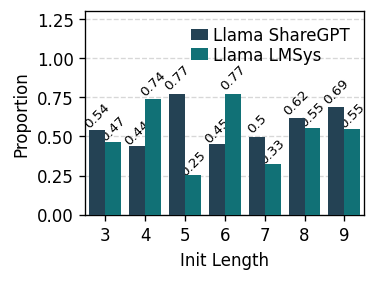

In [113]:
plt.figure(figsize=(3, 2.2), dpi=120)
def add_num_annotation(ax, rotation=0, fontsize=10):
    for _p in ax.patches:
        if _p.get_height() == 0:
            continue
        ax.annotate(
            str(round(_p.get_height(), 2)),
            (_p.get_x() + _p.get_width() / 2.0, _p.get_height() * 1.05),
            ha="center",
            va="center",
            xytext=(0, 6),
            textcoords="offset points",
            rotation=rotation,
            fontsize=fontsize,
        )
ax=sns.barplot(
    data=estimated_accuracy,
    x="init_length",
    y="accuracy",
    hue="models",
    zorder=10,
    palette=self_define_palette[:2]
)
add_num_annotation(ax, fontsize=8, rotation=45)
plt.ylim(0, 1.3)
plt.legend(
    loc="best",
    ncol=1,
    frameon=False,
    labelspacing=0.1,
    handlelength=1,
    handletextpad=0.3,
    columnspacing=0.3,
)
plt.xlabel("Init Length")
plt.ylabel("Proportion")
plt.grid(True, axis="y", alpha=0.5, ls="--", zorder=0)
plt.savefig("estimated_accuracy.pdf")
plt.show()

/tmp/ipykernel_2448464/578506617.py:31: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(data=data, hue="dataset", y="accuracy", x="models", zorder=10, palette=self_define_palette[:2])


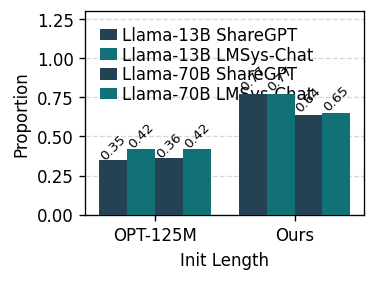

In [4]:
result = {
    "dataset": [
        "Llama-13B ShareGPT",
        "Llama-13B ShareGPT",
        "Llama-13B LMSys-Chat",
        "Llama-13B LMSys-Chat",
        "Llama-70B ShareGPT",
        "Llama-70B ShareGPT",
        "Llama-70B LMSys-Chat",
        "Llama-70B LMSys-Chat",
    ],
    "models": ["OPT-125M", "Ours", "OPT-125M", "Ours", "OPT-125M", "Ours", "OPT-125M", "Ours"],
    "accuracy": [0.35, 0.77, 0.42, 0.77, 0.36, 0.64, 0.42, 0.65],
}
plt.figure(figsize=(3, 2.2), dpi=120)
def add_num_annotation(ax, rotation=0, fontsize=10):
    for _p in ax.patches:
        if _p.get_height() == 0:
            continue
        ax.annotate(
            str(round(_p.get_height(), 2)),
            (_p.get_x() + _p.get_width() / 2.0, _p.get_height() * 1.05),
            ha="center",
            va="center",
            xytext=(0, 6),
            textcoords="offset points",
            rotation=rotation,
            fontsize=fontsize,
        )
data = pd.DataFrame(result)
ax = sns.barplot(data=data, hue="dataset", y="accuracy", x="models", zorder=10, palette=self_define_palette[:2])
add_num_annotation(ax, fontsize=8, rotation=45)
plt.ylim(0, 1.3)
plt.legend(
    loc="best",
    ncol=1,
    frameon=False,
    labelspacing=0.1,
    handlelength=1,
    handletextpad=0.3,
    columnspacing=0.3,
)
plt.xlabel("Init Length")
plt.ylabel("Proportion")
plt.grid(True, axis="y", alpha=0.5, ls="--", zorder=0)
plt.savefig("estimated_accuracy.pdf")
plt.show()

## test warm up window size

In [ ]:
def max_eos_prob_left_seq_len(row, i):
    if len(row) <= i:
        return pd.Series([-1, -1], index=["max_eos_prob", "left_seq_len"])
    # max_eos_prob = np.std(row["eos_prob"][:i]) / np.mean(
    #     row["eos_prob"][:i]
    # )
    max_eos_prob = np.max(row["eos_token_rank"][:i])
    left_seq_len = max(row["token_num"]) - min(row["token_num"][i:])
    tmp_df = pd.Series(
        [max_eos_prob, left_seq_len], index=["max_eos_prob", "left_seq_len"]
    )


corrs = []
for i in range(1, 50):
    eos_prob_left_seq_len = (
        eos_prob_rank_result_df.groupby(["request_id"])
        .parallel_apply(lambda row: max_eos_prob_left_seq_len(row, i))
        .reset_index()
        .drop(columns=["request_id"])
    )
    corrs.append(
        eos_prob_left_seq_len[eos_prob_left_seq_len["max_eos_prob"] >= 0]
        .corr(method="spearman")
        .loc["max_eos_prob", "left_seq_len"]
    )
plt.figure(figsize=(4, 2.5), dpi=150)
print(corrs)
sns.lineplot(corrs, hue="model_dataset")
plt.xlabel("# of Iters")
plt.ylabel("Corr. Seq Len vs. Prob")
plt.grid(alpha=0.3, linestyle="--")
plt.show()
print(corrs)

In [ ]:
def eos_prob_predict_len(row, i):
    if len(row) <= i:
        return pd.Series([-1, -1], index=["pred_len", "left_seq_len"])
    # max_eos_prob = np.std(row["eos_token_rank"][:i]) / np.mean(
    #     row["eos_prob"][:i]
    # )

    max_eos_prob = 1 - np.max(row["eos_token_rank"][:i]) / 32000
    _n = int(-np.log(np.max(row["eos_token_rank"][:i]))) + 23
    predict_len = (
        max_eos_prob
        * (1 + _n * max_eos_prob ** (_n + 1) - (_n + 1) * max_eos_prob**_n)
        / ((1 - max_eos_prob) ** 2)
    )

    left_seq_len = max(row["token_num"]) - min(row["token_num"][i:])
    return pd.Series(
        [predict_len, left_seq_len], index=["pred_len", "left_seq_len"]
    )


eos_pred_len_df = (
    eos_prob_rank_result_df.groupby(["request_id"])
    .apply(
        lambda row: eos_prob_predict_len(row, 3),
        include_groups=False,
    )
    .reset_index()
    .drop(columns=["request_id"])
)
eos_pred_len_df

In [ ]:
_tmp_eos_prob_rank_result_df = eos_prob_rank_result_df[
    eos_prob_rank_result_df["request_id"] == 0
]
_tmp_eos_prob_rank_result_df["left_seq_len"] = (
    max(_tmp_eos_prob_rank_result_df["token_num"])
    - _tmp_eos_prob_rank_result_df["token_num"]
)
_tmp_eos_prob_rank_result_df

/tmp/ipykernel_2448464/3840384447.py:10: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.barplot(
/tmp/ipykernel_2448464/3840384447.py:42: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.barplot(


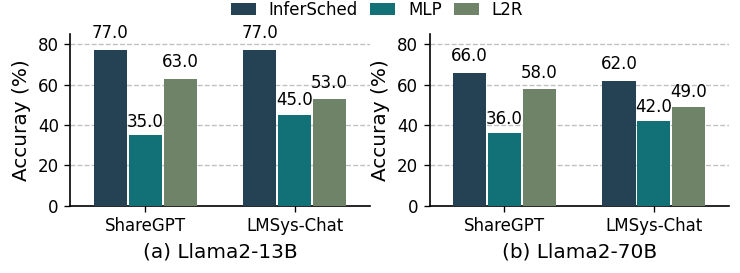

In [5]:
df = pd.read_csv("/root/vllm/examples/analysis/data/eos_result/eos_prob_accuracy.csv")
df['accuracy']=df['accuracy']*100
df.replace({"Ours":"InferSched"},inplace=True)
colors = ["#1C445C", "#008087", "#6D8764", "#A0522D", "#76608A"]
self_define_palette = sns.color_palette(colors)
ax=[]
fig = plt.figure(figsize=(6, 2), dpi=120)
ax.append(fig.add_subplot(121))
ax.append(fig.add_subplot(122))
sns.barplot(
    df[df["model"] == "llama-13b"],
    x="dataset",
    y="accuracy",
    hue="profile_method",
    palette=self_define_palette,
    hue_order=["InferSched", "MLP", "L2R"],
    width=0.7,
    dodge=True,
    gap=0.05,
    ax=ax[0],
    zorder=10,
)
ax[0].legend().remove()
# ax[0].legend(
#     title="",
#     frameon=False,
#     ncol=5,
#     loc=(0.5, 1),
#     handlelength=1.0,
#     columnspacing=0.5,
# )
ax[0].set_xlabel("(a) Llama2-13B", fontsize=12)
ax[0].set_ylabel("Accuray (%)", fontsize=12)
ax[0].grid(linestyle="--", alpha=0.8, axis="y", zorder=1)
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].spines["left"].set_color("black")
ax[0].spines["left"].set_linewidth(1)
ax[0].spines["bottom"].set_color("black")
ax[0].spines["bottom"].set_linewidth(1)
add_num_annotation(ax[0])
sns.barplot(
    df[df["model"] == "llama-70b"],
    x="dataset",
    y="accuracy",
    hue="profile_method",
    palette=self_define_palette,
    hue_order=["InferSched", "MLP", "L2R"],
    width=0.7,
    dodge=True,
    gap=0.05,
    ax=ax[1],
    zorder=10,
)
add_num_annotation(ax[1])
ax[1].legend().remove()
ax[1].set_xlabel("(b) Llama2-70B", fontsize=12)
ax[1].set_ylabel("Accuray (%)", fontsize=12)

# 设置网格线
ax[1].grid(linestyle="--", alpha=0.8, axis="y", zorder=1)

# 隐藏上、右边框
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
ax[1].spines["left"].set_color("black")
ax[1].spines["left"].set_linewidth(1)
ax[1].spines["bottom"].set_color("black")
ax[1].spines["bottom"].set_linewidth(1)

ax[0].set_ylim(0, 85)
ax[1].set_ylim(0, 85)
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="",
    frameon=False,
    ncol=5,
    loc=(0.3, 0.9),
    handlelength=1.5,
    columnspacing=0.7,
    fontsize=10,
    borderaxespad=0.5,
    borderpad=0.5,
)

plt.subplots_adjust(wspace=0.0)
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
plt.savefig("accuracy.pdf",bbox_inches='tight')